## Sakila - Logistic Regression

#### In order to optimize our inventory, we would like to predict if a film will have more monthly rentals in July than in June.

First things first: let's import the libraries will need for the exercise and establish our connection with SQL.

In [1]:
import pymysql
from sqlalchemy import create_engine
import getpass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
password = getpass.getpass() # password = 'password'

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

**1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.**

*In order to build the prediction model and bearing in mind that we want to predict if a film will have more monthly rentals in June than July, we should ask ourselves which features could have more influence over the rental decision. For example:*

- Does the film price influence the rental decision? It is likely.
- Is the category of the film important? In this case, it could be important as films are an entertainment product and June-July coincides with the summer break.
- What else could increase rentals in July? Maybe if there were a recent movie premiere or special discounts for that period, but we don't have that information. 

*Therefore, for this exercise we're going to get the following columns: rental_rate and film_category.*

In [4]:
# Let's query over the period we're interested in: June and July.

query = """
SELECT 
    f.title as title,
    f.rental_rate as rental_price,
    c.name as film_category
FROM rental AS r
LEFT JOIN payment AS p
ON r.rental_id = p.rental_id
LEFT JOIN inventory as i
ON r.inventory_id = i.inventory_id
LEFT JOIN film as f
ON i.film_id = f.film_id
LEFT JOIN film_category as fc
ON f.film_id = fc.film_id
LEFT JOIN category as c
ON fc.category_id = c.category_id
WHERE rental_date < '2006-01-01 00:00:00'
GROUP BY title
ORDER BY title ASC;
"""

sakila_df = pd.read_sql(query, engine)
sakila_df.head(20)

,title,rental_price,film_category
0,ACADEMY DINOSAUR,0.99,Documentary
1,ACE GOLDFINGER,4.99,Horror
2,ADAPTATION HOLES,2.99,Documentary
3,AFFAIR PREJUDICE,2.99,Horror
4,AFRICAN EGG,2.99,Family
5,AGENT TRUMAN,2.99,Foreign
6,AIRPLANE SIERRA,4.99,Comedy
7,AIRPORT POLLOCK,4.99,Horror
8,ALABAMA DEVIL,2.99,Horror
9,ALADDIN CALENDAR,4.99,Sports


2. Create a query to get the total amount of rentals in June for each film.

In [5]:
query_june = """
SELECT
    title,
    count(film_id) as num_rentals_june
FROM (
    SELECT 
        r.rental_id,
        r.rental_date,
        r.inventory_id,
        r.customer_id,
        i.film_id,
        f.title
    FROM rental as r
    LEFT JOIN inventory as i
    ON r.inventory_id = i.inventory_id
    LEFT JOIN film as f
    ON i.film_id = f.film_id
    WHERE rental_date BETWEEN '2005-06-01 00:00:00' AND '2005-06-30 23:59:59'
    ) as subq
GROUP BY title
ORDER BY num_rentals_june ASC;"""

june_df = pd.read_sql(query_june, engine)
june_df.head(10)

,title,num_rentals_june
0,WON DARES,1
1,JEKYLL FROGMEN,1
2,PARK CITIZEN,1
3,STAR OPERATION,1
4,TEMPLE ATTRACTION,1
5,RAGING AIRPLANE,1
6,WILD APOLLO,1
7,UNFAITHFUL KILL,1
8,NUTS TIES,1
9,TRAINSPOTTING STRANGERS,1


3. Do the same with July.

In [6]:
query_july = """
SELECT
    title,
    count(film_id) as num_rentals_july
FROM (
    SELECT 
        r.rental_id,
        r.rental_date,
        r.inventory_id,
        r.customer_id,
        i.film_id,
        f.title
    FROM rental as r
    LEFT JOIN inventory as i
    ON r.inventory_id = i.inventory_id
    LEFT JOIN film as f
    ON i.film_id = f.film_id
    WHERE rental_date BETWEEN '2005-07-01 00:00:00' AND '2005-07-31 23:59:59'
    ) as subq
GROUP BY film_id
ORDER BY num_rentals_july DESC;"""

july_df = pd.read_sql(query_july, engine)
july_df.head()

,title,num_rentals_july
0,SCALAWAG DUCK,16
1,GREATEST NORTH,15
2,PRIMARY GLASS,15
3,LOSE INCH,14
4,HARRY IDAHO,14


In [7]:
print('Sakilas df shape:', sakila_df.shape)
print('June rentals df shape:', june_df.shape)
print('July rentals df shape:', july_df.shape)

Sakilas df shape: (958, 3)
June rentals df shape: (900, 2)
July rentals df shape: (958, 2)


*Let's concatenate the three data frames to operate over one single data frame later on.*

In [8]:
summer_rentals = june_df.merge(july_df, on='title', how='right')
rentals_df = sakila_df.merge(summer_rentals, on = 'title', how = 'left')
print('Rentals df shape:', rentals_df.shape)
rentals_df.head()

Rentals df shape: (958, 5)


,title,rental_price,film_category,num_rentals_june,num_rentals_july
0,ACADEMY DINOSAUR,0.99,Documentary,3.0,9
1,ACE GOLDFINGER,4.99,Horror,NaN,2
2,ADAPTATION HOLES,2.99,Documentary,1.0,4
3,AFFAIR PREJUDICE,2.99,Horror,2.0,12
4,AFRICAN EGG,2.99,Family,2.0,5


**4.Create a new column containing (Yes/No) for each film whether or not the number of monthly rentals in July was bigger than in June. Your objective will be to predict this new column.**

In order to calculate whether the number of rentals in July is higher that the number of rentals in June, we can convert NaN values into zero. 

In [9]:
rentals_df = rentals_df.fillna(0)
rentals_df.head()

,title,rental_price,film_category,num_rentals_june,num_rentals_july
0,ACADEMY DINOSAUR,0.99,Documentary,3.0,9
1,ACE GOLDFINGER,4.99,Horror,0.0,2
2,ADAPTATION HOLES,2.99,Documentary,1.0,4
3,AFFAIR PREJUDICE,2.99,Horror,2.0,12
4,AFRICAN EGG,2.99,Family,2.0,5


We can also cast num_rentals_june float numbers into integer numbers before adding the new column.

In [10]:
rentals_df['num_rentals_june'] = rentals_df['num_rentals_june'].astype('int')
rentals_df.head()

,title,rental_price,film_category,num_rentals_june,num_rentals_july
0,ACADEMY DINOSAUR,0.99,Documentary,3,9
1,ACE GOLDFINGER,4.99,Horror,0,2
2,ADAPTATION HOLES,2.99,Documentary,1,4
3,AFFAIR PREJUDICE,2.99,Horror,2,12
4,AFRICAN EGG,2.99,Family,2,5


In [11]:
def higher_rentals(row):
    if (row['num_rentals_june'] < row['num_rentals_july']):
        return 'Yes'
    else:
        return 'No'

rentals_df['more_rentals_in_july'] = rentals_df.apply(higher_rentals, axis=1)
rentals_df.head()

,title,rental_price,film_category,num_rentals_june,num_rentals_july,more_rentals_in_july
0,ACADEMY DINOSAUR,0.99,Documentary,3,9,Yes
1,ACE GOLDFINGER,4.99,Horror,0,2,Yes
2,ADAPTATION HOLES,2.99,Documentary,1,4,Yes
3,AFFAIR PREJUDICE,2.99,Horror,2,12,Yes
4,AFRICAN EGG,2.99,Family,2,5,Yes


In [12]:
# Checking data types
rentals_df.dtypes

title                    object
rental_price            float64
film_category            object
num_rentals_june          int32
num_rentals_july          int64
more_rentals_in_july     object
dtype: object

In [13]:
# Checking nan values
rentals_df.isna().sum()

title                   0
rental_price            0
film_category           0
num_rentals_june        0
num_rentals_july        0
more_rentals_in_july    0
dtype: int64

*We can also get unique values of our data and check class imbalance for the class we are trying to predict.*

['Yes' 'No']
Yes    952
No       6
Name: more_rentals_in_july, dtype: int64


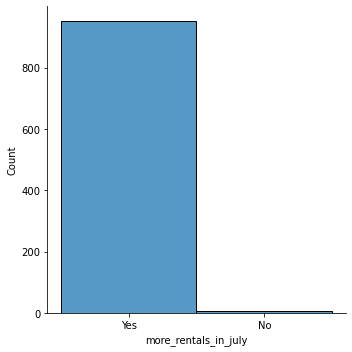

In [14]:
# Class imbalance on the column we want to predict is more than evident, 
# we have 99% of data labeled as 'Yes'. 
print(rentals_df['more_rentals_in_july'].unique())
print(rentals_df['more_rentals_in_july'].value_counts())

sns.displot(x = 'more_rentals_in_july', data = rentals_df)
plt.show()

**5. Analyze extracted features and transform them. You may need to encode some categorical variables or scale numerical variables.**

*When analyzing our extracted features, we have observed that rental_price data type could be considered categorical.*

In [15]:
rentals_df['rental_price'] = rentals_df['rental_price'].astype('object') 
print(rentals_df.dtypes)

title                   object
rental_price            object
film_category           object
num_rentals_june         int32
num_rentals_july         int64
more_rentals_in_july    object
dtype: object


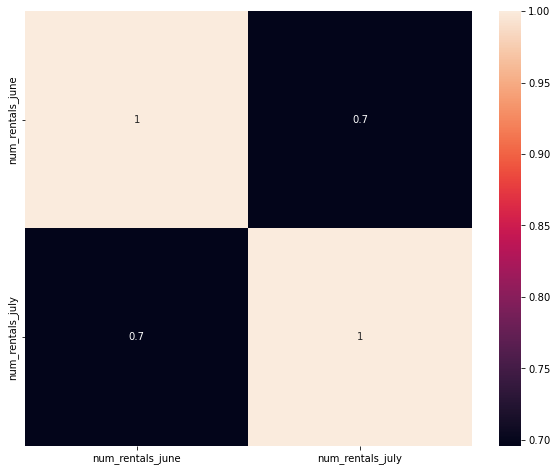

In [16]:
# Looking for multicolinearity in numerical data: one seems to be higly correlated 
# to the other one.
corr_matrix = rentals_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

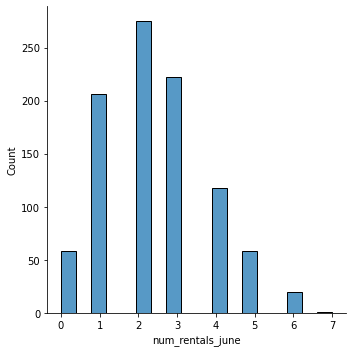

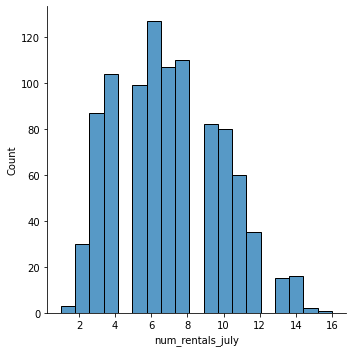

In [17]:
# Now let's take a look at the scale and distribution of values
sns.displot(rentals_df['num_rentals_june'])
sns.displot(rentals_df['num_rentals_july'])
plt.show()

6. Create a logistic regression model to predict this new column from the cleaned data.

In [18]:
# First step: X-y split
y = rentals_df['more_rentals_in_july']

# Dropping name films as it is not relevant for the model
X = rentals_df.drop(['title', 'more_rentals_in_july'], axis=1) 

In [19]:
# Second step: Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state= 42)

Once we have split our data, we can encode and/or apply transformers if necessary.

*Select and scale numeric train set data using MinMaxScaler*

In [20]:
# Selecting numerical data from train sample
X_train_num = X_train.select_dtypes(include = np.number)

# Initializing and applying MinMaxScaler transformer
transformer = MinMaxScaler().fit(X_train_num)
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns = X_train_num.columns)
X_train_norm.head()

,num_rentals_june,num_rentals_july
0,0.571429,0.600000
1,0.142857,0.133333
2,0.428571,0.333333
3,0.428571,0.266667
4,0.428571,0.466667


*Select and scale numeric test set data using MinMaxScaler*

In [21]:
# Selecting numerical data from test sampe
X_test_num = X_test.select_dtypes(include = np.number)

# Applying MinMaxScaler transformer
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns = X_test_num.columns)
X_test_norm.head()

,num_rentals_june,num_rentals_july
0,0.571429,0.800000
1,0.142857,0.266667
2,0.142857,0.200000
3,0.428571,0.600000
4,0.714286,0.866667


Now let's handle categorical data

In [22]:
#Selecting categorical data from train sample
X_train_categorical = X_train.select_dtypes(include = 'object')

# Encoding categorical data
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rental_price', 'film_category'],
                             drop_first=True)
X_train_cat.head()

C:\Users\ameli\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,rental_price_2.99,rental_price_4.99,film_category_Animation,film_category_Children,film_category_Classics,film_category_Comedy,film_category_Documentary,film_category_Drama,film_category_Family,film_category_Foreign,film_category_Games,film_category_Horror,film_category_Music,film_category_New,film_category_Sci-Fi,film_category_Sports,film_category_Travel
228,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
715,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
212,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
#Selecting categorical data from test sample
X_test_categorical = X_test.select_dtypes(include = 'object')

# Encoding categorical data
X_test_cat = pd.get_dummies(X_test_categorical, 
                             columns=['rental_price', 'film_category'],
                             drop_first=True)
X_test_cat.head()

C:\Users\ameli\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,rental_price_2.99,rental_price_4.99,film_category_Animation,film_category_Children,film_category_Classics,film_category_Comedy,film_category_Documentary,film_category_Drama,film_category_Family,film_category_Foreign,film_category_Games,film_category_Horror,film_category_Music,film_category_New,film_category_Sci-Fi,film_category_Sports,film_category_Travel
836,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
477,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
350,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
891,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
855,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [24]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)
X_train_transformed

array([[0.57142857, 0.6       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.13333333, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.42857143, 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.57142857, 0.6       , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.13333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28571429, 0.46666667, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [25]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)
X_test_transformed

array([[0.57142857, 0.8       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.26666667, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.14285714, 0.2       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14285714, 0.2       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28571429, 0.4       , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.71428571, 0.6       , 0.        , ..., 0.        , 0.        ,
        0.        ]])

*Now we'll fit the logistic regression model on train set and apply it to test set.*

In [26]:
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='auto').fit(X_train_transformed, y_train)

y_test_pred = classification.predict(X_test_transformed)

In [27]:
print('Classification score:', classification.score(X_test_transformed, y_test))
predicted_values_unique, num = np.unique(y_test_pred, return_counts = True)
print('Predicted values on test / Count:', predicted_values_unique, num)

Classification score: 0.9965277777777778
Predicted values on test / Count: ['Yes'] [288]


#### 7. Evaluate the results.

In [28]:
print("The accuracy is: {:.2f}".format(accuracy_score(y_test,y_test_pred)))
print("The precision is: {:.2f}".format(precision_score(y_test,y_test_pred, pos_label = 'Yes')))
print("The recall is: {:.2f}".format(recall_score(y_test,y_test_pred, pos_label = 'Yes')))
print("The F1 is: {:.2f}".format(f1_score(y_test,y_test_pred, pos_label = 'Yes')))
print("The Kappa is: {:.2f}".format(cohen_kappa_score(y_test,y_test_pred)))

The accuracy is: 1.00
The precision is: 1.00
The recall is: 1.00
The F1 is: 1.00
The Kappa is: 0.00


C:\Users\ameli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Yes    287
No       1
Name: more_rentals_in_july, dtype: int64


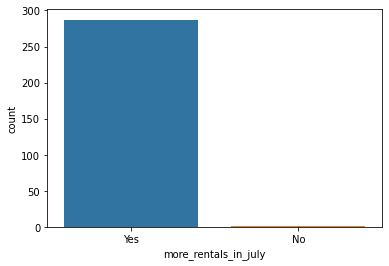

In [29]:
print(y_test.value_counts())
sns.countplot(y_test)
plt.show()

C:\Users\ameli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


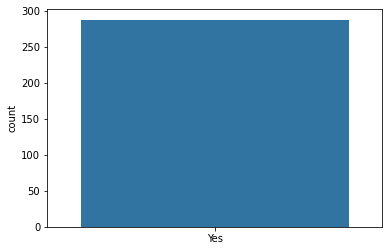

In [30]:
pd.Series(y_test_pred).value_counts()
sns.countplot(y_test_pred)
plt.show()

In [31]:
confusion_matrix(y_test, y_test_pred)

array([[  0,   1],
       [  0, 287]], dtype=int64)

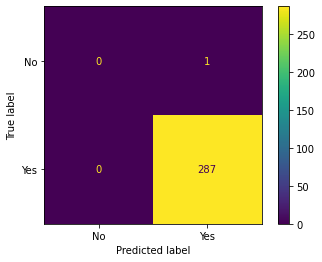

In [32]:
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test, display_labels =  classification.classes_)
disp.plot()
plt.show()

*The results we're seeing indicate that the model is predicting almost perfectly the labels of our predictor. However, these metrics are tricky: due to the huge class imbalance, our model is only good at predicting 'Yes' labels (in fact, there's only one False Positive). Our Kappa Score is 0: there is random agreement between the predicted label and true labels.*